In [1]:
!pip install -U jaxlib[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jax[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability==0.17
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt update
!apt install -y graphviz
!pip install graphviz
!pip install gplearn
!pip install optuna

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 13.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.4.2-py3-none-any.whl size=1363010 sha256=7deabe2355a69952bb621d039049034fb8e90f67632d8b2f1bb6346e7d9f0176
  Stored in directory: /root/.cache/pip/wheels/dc/4f/2b/e0dd187e3644b96d8d54f832ec9f9a4560dfb0a896f55dffe4
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
   

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
import haiku as hk
import numpy as np
import optax
from nn_util import *
from optim_util import *
plt.style.use('ggplot')
%load_ext autoreload

In [3]:
if SERVER:
    data_dir = "/home/bizon/bio_ai"
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

### GDSC Cell Line

#### Tamoxifen

In [4]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_tamox_data = pd.read_csv(f"{gdsc_dir}/tamoxifen_response_gene_expr.csv")
gdsc_exp_tamox_data.shape

(406, 37265)

In [5]:
X, target = gdsc_exp_tamox_data.iloc[:,:-1], gdsc_exp_tamox_data.iloc[:,-1]
# change to -log10(IC_50) to make it comparable
target = -np.log10(np.exp(target)) # exp b/c the values are natural logs of raw IC_50
cancer_driver_genes_df = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")

In [6]:
cols = X.columns.to_list()
driver_syms = cancer_driver_genes_df["symbol"].to_list()
driver_sym_list = [sym.strip() for sym in cols if sym in driver_syms]

In [7]:
landmark_genes_df = pd.read_table(f"{data_dir}/cell_line/cmap_L1000_genes.txt")
landmark_genes = [sym.strip() for sym in landmark_genes_df["Symbol"].to_list() if sym in cols]
len(landmark_genes)

970

In [8]:
X_selected = X[driver_sym_list]
X_selected.shape

(406, 768)

In [9]:
X_selected_lm = X[landmark_genes]
X_selected_lm.shape

(406, 970)

In [10]:
len(set(driver_sym_list) & set(landmark_genes))

108

#### Data Preprocessing

In [11]:
seed = 57
X_train_outer_df, X_test_df, y_train_outer_df, y_test_df = train_test_split(X_selected, target, random_state=seed, shuffle=True, test_size=0.2)

In [12]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler, Normalizer, StandardScaler

train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_outer_df)
# train_transformer = PowerTransformer().fit(X_train_df)
train_transformed = train_transformer.transform(X_train_outer_df)
test_transformed = train_transformer.transform(X_test_df)

X_train_outer_df = pd.DataFrame(train_transformed, columns=X_train_outer_df.columns)
X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (324). n_quantiles is set to n_samples.
  warnings.warn(


In [13]:
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_outer_df, y_train_outer_df, shuffle=True,
                                                              random_state=seed, test_size=0.2)
train_indices, val_indices = X_train_df.index.to_list(), X_val_df.index.to_list()

In [4]:
X_train_outer, y_train_outer = X_train_outer_df.values, y_train_outer_df.values
X_train, y_train = X_train_df.values, y_train_df.values
X_val, y_val = X_val_df.values, y_val_df.values
X_test, y_test = X_test_df.values, y_test_df.values

NameError: name 'X_train_outer_df' is not defined

#### BNN without BG

In [14]:
class BayesNN():
    def __init__(self, sgd_optim, sgld_optim, temperature, sigma, data_size, hidden_sizes, act_fn=jax.nn.relu):
        self.hidden_sizes = hidden_sizes
        self.act_fn = act_fn
        self.sgd_optim = sgd_optim
        self.sgld_optim = sgld_optim
        self.optimiser = sgd_optim
        self._forward = hk.without_apply_rng(hk.transform(self._forward_fn))
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

        self.temperature = temperature
        self.sigma = sigma
        self.data_size = data_size
        self.add_noise = False

        # weight_decay = self.sigma*self.temperature
        # self.weight_prior = tfd.Normal(0, self.sigma)
        self.weight_prior = tfd.StudentT(df=2, loc=0, scale=self.sigma)
        # self.weight_prior = tfd.Laplace(0, self.sigma)

    def init(self, rng, x):
        params = self._forward.init(rng, x)
        opt_state = self.optimiser.init(params)
        return params, opt_state

    def apply(self, params, x):
        return self._forward.apply(params, x).ravel()


    def update(self, key, params, opt_state, x, y):
        if self.add_noise:
            self.optimiser = self.sgld_optim
        else:
            self.optimiser = self.sgd_optim
        grads = jax.grad(self.loss)(params, x, y)
        updates, opt_state = self.optimiser.update(key, grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    def _forward_fn(self, x):
        init_fn = hk.initializers.VarianceScaling()
        for hd in self.hidden_sizes:
            x = hk.Linear(hd, w_init=init_fn, b_init=init_fn)(x)
            x = self.act_fn(x)

        x = hk.Linear(1)(x)
        return x

    def log_prior(self, params):
        """Computes the Gaussian prior log-density."""
        logprob_tree = jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: jnp.sum(self.weight_prior.log_prob(x.reshape(-1))/self.temperature),
                                                                        params))

        return sum(logprob_tree)

    def log_likelihood(self, params, x, y):
        preds = self.apply(params, x).ravel()
        log_prob = jnp.sum(tfd.Normal(preds, self.temperature).log_prob(y))
        batch_size = x.shape[0]
        log_prob = (self.data_size / batch_size)*log_prob
        return log_prob

    def loss(self, params, x, y):
        logprob_prior = self.log_prior(params)
        logprob_likelihood = self.log_likelihood(params, x, y)
        return logprob_likelihood + logprob_prior


#### BNN with BG

In [52]:
class BgBayesNN():
    def __init__(self, sgd_optim, sgld_optim, disc_sgd_optim, disc_sgld_optim, 
                        temperature, sigma, data_size, hidden_sizes, 
                        J, eta, mu, alpha,
                        act_fn, init_fn):
        self.hidden_sizes = hidden_sizes
        self.act_fn = act_fn
        self.sgd_optim = sgd_optim
        self.sgld_optim = sgld_optim
        self.optimiser = sgd_optim

        self.disc_optimiser = disc_sgd_optim
        self.disc_sgd_optim = disc_sgd_optim
        self.disc_sgld_optim = disc_sgld_optim

        self._forward = hk.transform(self._forward_fn)
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

        self.temperature = temperature
        self.sigma = sigma
        self.data_size = data_size
        self.add_noise = False
        self.J = J
        self.eta = eta
        self.mu = mu
        self.alpha = alpha
        self.init_fn = init_fn

        # weight_decay = self.sigma*self.temperature
        # self.weight_prior = tfd.Normal(0, self.sigma)
        self.weight_prior = tfd.StudentT(df=2, loc=0, scale=self.sigma)

    def init(self, rng, x):
        gamma = tfd.Bernoulli(0.5*jnp.ones(x.shape[-1])).sample(seed=rng)*1.
        params = self._forward.init(rng, x, gamma)
        opt_state = self.optimiser.init(params)
        disc_opt_state = self.disc_optimiser.init(gamma)
        return params, gamma, opt_state, disc_opt_state

    def apply(self, params, gamma, x):
        return self._forward.apply(params, None, x, gamma).ravel()

    
    def loss(self, params, gamma, x, y):
        logprob_prior = self.log_prior(params)
        logprob_likelihood = self.log_likelihood(params, gamma, x, y)
        return logprob_likelihood + logprob_prior

    def update(self, key, params, gamma, opt_state, disc_opt_state, x, y):
        if self.add_noise:
            self.optimiser = self.sgld_optim
            self.disc_optimiser = self.disc_sgld_optim
        else:
            self.optimiser = self.sgd_optim
            self.disc_optimiser = self.disc_sgd_optim

        contin_loss = lambda p: self.log_prior(params) + self.log_likelihood(p, gamma, x, y)
        # contin_loss = lambda p: self.log_likelihood(p, gamma, x, y)

        grads = jax.grad(contin_loss)(params)
        updates, opt_state = self.optimiser.update(key, grads, opt_state)
        params = optax.apply_updates(params, updates)

        disc_loss = lambda g: self.alpha*self.ising_prior(g) + self.log_likelihood(params, g, x, y)
        disc_logprob, disc_grads = jax.value_and_grad(disc_loss)(gamma)
        gamma, disc_opt_state = self.disc_optimiser.update(key, gamma, disc_grads, disc_opt_state)
        return params, gamma, opt_state, disc_opt_state

    def _forward_fn(self, x, gamma):
        x = x @ jnp.diag(gamma)
        for hd in self.hidden_sizes:
            x = hk.Linear(hd, w_init=self.init_fn)(x)
            x = self.act_fn(x)

        x = hk.Linear(1)(x)
        return x

    def log_prior(self, params):
        """Computes the Gaussian prior log-density."""
        logprob_tree = jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: jnp.sum(self.weight_prior.log_prob(x.reshape(-1)) / self.temperature),
                                                                            params))
        
        return sum(logprob_tree)

    def log_likelihood(self, params, gamma, x, y):
        preds = self.apply(params, gamma, x).ravel()
        log_prob = jnp.sum(tfd.Normal(preds, self.temperature).log_prob(y))
        batch_size = x.shape[0]
        log_prob = (self.data_size/batch_size)*log_prob

        # l2_regulariser = 0.5 * sum(
        #     jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))

        return log_prob

    def ising_prior(self, gamma):
        """Log probability of the Ising model - prior over the discrete variables"""
        return (-0.5*self.eta*(gamma.T @ self.J @ gamma) - self.mu*jnp.sum(gamma)) / self.temperature

In [16]:
from sklearn.metrics import r2_score
import torch
torch.backends.cudnn.deterministic = True

def init_bnn_model(seed, train_loader, epochs, lr_0, num_cycles, temp, sigma, hidden_sizes, act_fn):
    torch.manual_seed(seed)
    num_batches = len(train_loader)
    data_size = X.shape[0]
    total_steps = num_batches*epochs
    step_size_fn = make_cyclical_lr_fn(lr_0, total_steps, num_cycles)
    sgd_optim = sgd_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())
    sgld_optim = sgld_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())

    model = BayesNN(sgd_optim, sgld_optim,
                      temp, sigma, data_size, hidden_sizes, act_fn)

    return model


def train_bnn_model(seed, train_loader, epochs, num_cycles, beta, lr_0,
                       hidden_sizes, temp, sigma, act_fn=jax.nn.relu):

    rng_key = jax.random.PRNGKey(seed)
    model = init_bnn_model(seed, train_loader, epochs, lr_0, num_cycles, temp, sigma, hidden_sizes, act_fn)

    # cycle_len = epochs // num_cycles
    num_batches = len(train_loader)
    M = (epochs*num_batches) // num_cycles
    init_params, init_opt_state = model.init(rng_key, next(iter(train_loader))[0])


    states = []
    params, opt_state = init_params, init_opt_state
    step = 0
    key = rng_key
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            _, key = jax.random.split(key, 2)
            rk = (step % M) / M
            params, opt_state = model.update(key, params, opt_state, batch_x, batch_y)
            if rk > beta:
                model.add_noise = True
                states.append(params)
            else:
                model.add_noise = False
            step += 1

    return model, states

def eval_bnn_model(model, X, y, params):

    if isinstance(params, list):
        y_preds = np.zeros((len(params), len(y)))
        for i, param in enumerate(params):
            preds = model.apply(param, X).ravel()
            y_preds[i] = preds

        y_preds = np.mean(y_preds, axis=0)
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    else:
        y_preds = model.apply(params, X).ravel()
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))

    return rmse

def score_bnn_model(model, X, y, params):
    if isinstance(params, list):
        y_preds = np.zeros((len(params), len(y)))
        for i, param in enumerate(params):
            preds = model.apply(param, X).ravel()
            # preds_mean = preds[::2]
            y_preds[i] = preds

        y_preds = np.mean(y_preds, axis=0)
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
        if np.isfinite(y_preds).all():
            r2 = r2_score(y, y_preds)
        else:
            r2 = np.nan
    else:
        y_preds = model.apply(params, X)
        preds_mean = y_preds[::2]
        rmse = jnp.sqrt(jnp.mean((y - preds_mean)**2))
        if np.isfinite(y_preds).all():
            r2 = r2_score(y, y_preds)
        else:
            r2 = np.nan

    return rmse, r2

def eval_per_model_score(model, X, y, params):
    scores = []

    for param in params:
        preds = model.apply(param, X).ravel()
        # preds_mean = preds[::2]
        rmse = jnp.sqrt(jnp.mean((y - preds)**2))
        scores.append(rmse)



    return np.array(scores)

In [17]:
J = np.load(f"{data_dir}/cell_line/cancer_genes_net.npy")
J_lm = np.load(f"{data_dir}/cell_line/landmark_genes_net.npy")
print(np.count_nonzero(J))
print(np.count_nonzero(J_lm))

11862
9186


In [49]:
from scipy.sparse import csgraph
L = csgraph.laplacian(J, normed=False)
L

array([[ 0.   , -0.   , -0.   , ..., -0.   , -0.   , -0.   ],
       [-0.   , 20.393, -0.   , ..., -0.   , -0.   , -0.   ],
       [-0.   , -0.   , 15.877, ..., -0.   , -0.   , -0.   ],
       ...,
       [-0.   , -0.   , -0.   , ..., 39.532, -0.   , -0.   ],
       [-0.   , -0.   , -0.   , ..., -0.   ,  5.724, -0.   ],
       [-0.   , -0.   , -0.   , ..., -0.   , -0.   ,  2.819]])

#### Training loop

In [18]:
import torch
from sklearn.metrics import r2_score

def get_act_fn(name):
    if name == "relu":
        return jax.nn.relu
    if name == "swish":
        return jax.nn.swish
    if name == "tanh":
        return jax.nn.tanh
    if name == "sigmoid":
        return jax.nn.sigmoid
    if name == "celu":
        return jax.nn.celu
    if name == "relu6":
        return jax.nn.relu6
    if name == "glu":
        return jax.nn.glu
    if name == "elu":
        return jax.nn.elu
    if name == "leaky_relu":
        return jax.nn.leaky_relu
    if name == "log_sigmoid":
        return jax.nn.log_sigmoid

    return ValueError(f"Unknown activation function: {name}")

def init_bg_bnn_model(seed, train_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J, eta, mu, alpha, act_fn, init_fn):
    torch.manual_seed(seed)
    num_batches = len(train_loader)
    data_size = X.shape[0]
    total_steps = num_batches*epochs
    step_size_fn = make_cyclical_lr_fn(lr_0, total_steps, num_cycles)
    disc_step_size_fn = make_cyclical_lr_fn(disc_lr_0, total_steps, num_cycles)
    # disc_step_size_fn = lambda step: disc_lr_0
    sgd_optim = sgd_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())
    sgld_optim = sgld_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())

    disc_sgd_optim = disc_sgld_gradient_update(disc_step_size_fn, momentum_decay=0, preconditioner=get_identity_preconditioner())
    disc_sgld_optim = disc_sgld_gradient_update(disc_step_size_fn, momentum_decay=0, preconditioner=get_identity_preconditioner())

    model = BgBayesNN(sgd_optim, sgld_optim, disc_sgd_optim, disc_sgld_optim,
                      temp, sigma, data_size, hidden_sizes,
                      J, eta, mu, alpha, act_fn, init_fn)

    return model


def train_bg_bnn_model(seed, train_loader, epochs, num_cycles, beta, beta_noise, lr_0, disc_lr_0,
                    hidden_sizes, temp, sigma, eta, mu, alpha, J, act_fn_name):

    rng_key = jax.random.PRNGKey(seed)
    act_fn = get_act_fn(act_fn_name)

    # if act_fn_name in ["relu", "relu6", "leaky_relu", "swish"]:
    #     init_fn = hk.initializers.VarianceScaling(2.0, "fan_in",  "truncated_normal")
    # else:
    #     init_fn = hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal")
    init_fn = hk.initializers.VarianceScaling()

    model = init_bg_bnn_model(seed, train_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J, eta, mu, alpha, act_fn, init_fn)

    num_batches = len(train_loader)
    M = (epochs*num_batches) // num_cycles
    # cycle_len = epochs // num_cycles
    init_params, init_gamma, init_opt_state, init_disc_opt_state = model.init(rng_key, next(iter(train_loader))[0])

    states = []
    disc_states = []
    params, gamma, opt_state, disc_opt_state = init_params, init_gamma, init_opt_state, init_disc_opt_state
    step = 0
    key = rng_key
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            _, key = jax.random.split(key, 2)
            rk = (step % M) / M
            params, gamma, opt_state, disc_opt_state = model.update(key, params, gamma, opt_state, disc_opt_state, batch_x, batch_y)
            if rk > beta_noise:
                model.add_noise = True
            else:
                model.add_noise = False

            if rk > beta:
                states.append(params)
                disc_states.append(gamma)

            step += 1
        # if (epoch % cycle_len) + 1 > (cycle_len - n_models_per_cycle):
        #     # print(epoch)
        #     states.append(params)
        #     disc_states.append(gamma)
        # val_loss = eval_bg_bnn_model(model, X_val, y_val, params, gamma)
        # val_losses.append(val_loss)

    return model, states, disc_states

def eval_bg_bnn_model(model, X, y, params, gammas):

    if isinstance(params, list):
        y_preds = np.zeros((len(params), len(y)))
        for i, (param, gamma) in enumerate(zip(params, gammas)):
            preds = model.apply(param, gamma, X).ravel()
            y_preds[i] = preds

        y_preds = np.mean(y_preds, axis=0)
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    else:
        y_preds = model.apply(params, gammas, X).ravel()
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))

    return rmse

def score_bg_bnn_model(model, X, y, params, gammas):
    if isinstance(params, list):
        y_preds = np.zeros((len(params), len(y)))
        for i, (param, gamma) in enumerate(zip(params, gammas)):
            preds = model.apply(param, gamma, X).ravel()
            # preds_mean = preds[::2]
            y_preds[i] = preds

        y_preds = np.mean(y_preds, axis=0)
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
        if np.isfinite(y_preds).all():
            r2 = r2_score(y, y_preds)
        else:
            r2 = np.nan
    else:
        y_preds = model.apply(params, gammas, X)
        preds_mean = y_preds[::2]
        rmse = jnp.sqrt(jnp.mean((y - preds_mean)**2))
        if np.isfinite(y_preds).all():
            r2 = r2_score(y, y_preds)
        else:
            r2 = np.nan

    return rmse, r2

def eval_per_model_score_bg(model, X, y, params, gammas):
    scores = []

    for param, gamma in zip(params, gammas):
        preds = model.apply(param, gamma, X).ravel()
        # preds_mean = preds[::2]
        rmse = jnp.sqrt(jnp.mean((y - preds)**2))
        scores.append(rmse)



    return np.array(scores)

##### Dropout Loss

In [11]:
def evaluate_bnn_bg_models(model, X, y, params, gammas):
    eval_fn = lambda p, g: model.apply(p, g, X).ravel()
    preds = jax.vmap(eval_fn)(params, gammas)
    preds = preds.reshape(-1, preds.shape[-1])
    losses = jax.vmap(lambda x, z: jnp.sqrt(jnp.mean((x - z)**2)), in_axes=(0, None))(preds, y)
    # mean_loss = jnp.sqrt(jnp.mean(losses, axis=-1))
    return jnp.mean(losses)


def get_feats_dropout_loss(model, params, gammas, X, y):
    var_loss_dict = {"feats_idx": [], "num_models": [] , "loss_on": [], "loss_off": [], "loss_diff": []}
    
    disc_states = tree_utils.tree_stack(gammas)
    contin_states = tree_utils.tree_stack(params)

    eval_fn = jax.jit(lambda X, y, params, gammas: evaluate_bnn_bg_models(model, X, y, params, gammas))
    p = X.shape[1]

    for idx in range(p):
        idx_on = np.argwhere(disc_states[:,idx] == 1.).ravel()
        loss_on, loss_off = 0., 0.
        if idx_on.size == 0: ## irrelevant feature
            loss_diff = 1e9
        else:
            disc_states_on = disc_states[idx_on]
            params_on = jax.tree_util.tree_map(lambda x: x[idx_on], contin_states)
            loss_on = eval_fn(X, y, params_on, disc_states_on)

            # Turn-off the variable, and see how the loss changes
            disc_states_off = disc_states_on.at[:,idx].set(0)
            loss_off = eval_fn(X, y, params_on, disc_states_off)

            # loss_diff = (loss_on - loss_off) * (len(idx_on) / num_models)
            loss_diff = (loss_on - loss_off)


        var_loss_dict["feats_idx"].append(idx)
        var_loss_dict["num_models"].append(idx_on.size)
        var_loss_dict["loss_on"].append(loss_on)
        var_loss_dict["loss_off"].append(loss_off)
        var_loss_dict["loss_diff"].append(loss_diff)


    var_loss_df = pd.DataFrame(var_loss_dict).sort_values(by="loss_diff")

    return var_loss_df

def get_gene_names(gene_cols):
    return [gene.split("(")[0].strip() for gene in gene_cols]

##### Optuna

In [12]:
import optuna
from operator import itemgetter

def objective(trial, seed, x_train, x_val, y_train, y_val, J, epochs, beta, beta_noise,
              batch_size, hidden_sizes, act_fn, bg=True):

    num_cycles = 50
    beta, beta_noise = 0.99, 0.3
    lr_0, disc_lr_0 = 1e-3, 0.5
    temp = trial.suggest_categorical("temp", [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.])
    sigma = 1.0
    if bg:
        eta = trial.suggest_float("eta", 1.0, 1e2)
    else:
        eta = 1.0
    mu = trial.suggest_float("mu", 1.0, 1e2)

    M = 10


    torch.manual_seed(seed)
    data_loader = NumpyLoader(NumpyData(x_train, y_train), batch_size=batch_size, shuffle=False, drop_last=True)


    bg_bnn_model, states, disc_states = train_bg_bnn_model(seed, data_loader, epochs, num_cycles, beta, beta_noise, lr_0, disc_lr_0,
                                                           hidden_sizes, temp, sigma, eta, mu, alpha, J, act_fn)

    val_losses = eval_per_model_score_bg(bg_bnn_model, x_val, y_val, states, disc_states)
    model_idxs = jnp.argsort(val_losses).squeeze()[:M]
    states_sel, disc_states_sel = list(itemgetter(*model_idxs)(states)), list(itemgetter(*model_idxs)(disc_states))
    rmse = eval_bg_bnn_model(bg_bnn_model, x_val, y_val, states_sel, disc_states_sel)

    return rmse

In [199]:
optuna.logging.set_verbosity(optuna.logging.INFO)
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler)
# act_fn = jax.nn.swish
study.optimize(lambda trial: objective(trial, seed, X_train, X_val, y_train, y_val, J, 1000, 0.99, 0.3, 16, [500], "swish"), timeout=120)

[I 2023-01-31 11:40:01,706] A new study created in memory with name: no-name-58cae751-3dbe-4b19-975d-f3fd6c3c58a2
[I 2023-01-31 11:40:33,135] Trial 0 finished with value: 0.44382748007774353 and parameters: {'eta': 72.83127510216542, 'mu': 29.765881735911844}. Best is trial 0 with value: 0.44382748007774353.
[I 2023-01-31 11:41:04,039] Trial 1 finished with value: 0.4497864246368408 and parameters: {'eta': 17.868812604271895, 'mu': 9.210671559757277}. Best is trial 0 with value: 0.44382748007774353.
[I 2023-01-31 11:41:35,058] Trial 2 finished with value: 0.4516977369785309 and parameters: {'eta': 39.26543589516153, 'mu': 15.051395065272855}. Best is trial 0 with value: 0.44382748007774353.
[I 2023-01-31 11:42:05,573] Trial 3 finished with value: 0.4438244104385376 and parameters: {'eta': 53.5880084803282, 'mu': 41.06212983700065}. Best is trial 3 with value: 0.4438244104385376.


In [198]:
def zero_out(model, X, y, states, disc_states, m, dropout_df):
    feat_idxs = dropout_df["feats_idx"].iloc[:m].to_list()
    mask = np.zeros(X.shape[1])
    mask[feat_idxs] = 1.0
    X_mask = X @ np.diag(mask)
    rmse, _ = score_bg_bnn_model(model, X_mask, y, states, disc_states)
    return rmse


#### Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score

def train_rf_model(seed, X, y, train_idxs, val_idxs):

    # cv = KFold(n_splits=5)
    cv = [(train_idxs, val_idxs) for _ in range(5)]
    param_grid = {
        'max_depth': [80, 100, 120],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 500, 1000]
    }

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=1.0)
    grid_cv = GridSearchCV(estimator = rf_reg, param_grid = param_grid,
                           cv = cv, n_jobs = -1, verbose = 0, scoring="neg_root_mean_squared_error").fit(X, y)

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=1.0, **grid_cv.best_params_)
    rf_reg.fit(X, y)

    return rf_reg

def eval_rf_model(model, X, y):
    y_preds = model.predict(X)
    rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    r2 = r2_score(y, y_preds)
    return rmse, r2

#### Multiple Runs

In [13]:
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
import pickle
import warnings
from operator import itemgetter

warnings.filterwarnings("ignore")


epochs = 1000
num_cycles = 50
batch_size = 16
act_fn = "swish"
beta, beta_noise = 0.99, 0.3
lr_0, disc_lr_0 = 1e-3, 0.5
hidden_sizes = [500]
# temp, sigma = 1e-4, 1.0
sigma = 1.0
# eta, mu = 1.0, 1.0
alpha = 1.0

M = 30

# epochs = 200
# hidden_sizes = [512, 256, 128, 64, 32]
# beta_noise = 0.25
# batch_size = 32
# act_fn = "relu"

save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"

optuna.logging.set_verbosity(optuna.logging.WARNING)

# bg_bnn_configs = []
# bnn_configs = []

VERSION = "9g"

def cross_val_run(seeds, X, y, J):
    J_zero = np.zeros_like(J)

    i = 0
    for seed in tqdm(seeds):
        # if not os.path.exists(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v{VERSION}.csv"):
        bnn_rf_bg_dict = {"seed":[], "model": [], "test_rmse": [], "test_r2_score": []}
        X_train_outer_df, X_test_df, y_train_outer_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

        train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_outer_df)
        train_transformed = train_transformer.transform(X_train_outer_df)
        test_transformed = train_transformer.transform(X_test_df)

        X_train_outer_df = pd.DataFrame(train_transformed, columns=X_train_outer_df.columns)
        X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)

        X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_outer_df, y_train_outer_df, shuffle=True,
                                                                      random_state=seed, test_size=0.2)


        train_indices, val_indices = X_train_df.index.to_list(), X_val_df.index.to_list()
        X_train_outer, y_train_outer = X_train_outer_df.values, y_train_outer_df.values
        X_train, y_train = X_train_df.values, y_train_df.values
        X_val, y_val = X_val_df.values, y_val_df.values
        X_test, y_test = X_test_df.values, y_test_df.values

        torch.manual_seed(seed)
        outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=batch_size, shuffle=True)

        ### BNN + BG
        sampler = optuna.samplers.TPESampler(seed=seed)
        study = optuna.create_study(sampler=sampler)
        study.optimize(lambda trial: objective(trial, seed, X_train, X_val, y_train, y_val, J, epochs, beta, beta_noise, batch_size, hidden_sizes, act_fn, bg=True), timeout=180)
        bnn_bg_config = study.best_params

        # bnn_bg_config = pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v9f.pkl", "rb"))

        eta, mu = bnn_bg_config["eta"], bnn_bg_config["mu"]
        temp = bnn_bg_config["temp"]
        bg_bnn_model, bg_bnn_states, bg_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles, beta, beta_noise, lr_0, disc_lr_0,
                                                                         hidden_sizes, temp, sigma, eta, mu, alpha, J, act_fn)

        bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model, X_test, y_test, bg_bnn_states, bg_disc_states)




        # pickle.dump(bg_bnn_states, open(f"{save_dir}/checkpoints/bg_bnn_states_s_{seed}_v{VERSION}.pkl", "wb"))
        # pickle.dump(bg_disc_states, open(f"{save_dir}/checkpoints/bg_bnn_disc_states_s_{seed}_v{VERSION}.pkl", "wb"))
        pickle.dump(bnn_bg_config ,open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v9{VERSION}.pkl", "wb"))

        ### BNN w/o BG
        sampler = optuna.samplers.TPESampler(seed=seed)
        study = optuna.create_study(sampler=sampler)
        study.optimize(lambda trial: objective(trial, seed, X_train, X_val, y_train, y_val, J_zero, epochs, beta, beta_noise, batch_size, hidden_sizes, act_fn, bg=False), timeout=180)
        bnn_config = study.best_params

        # bnn_config = pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v9f.pkl", "rb"))

        eta, mu = 1.0, bnn_config["mu"]
        temp = bnn_config["temp"]
        bnn_model, bnn_states, bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles, beta, beta_noise, lr_0, disc_lr_0,
                                                                         hidden_sizes, temp, sigma, eta, mu, alpha, J_zero, act_fn)

        bnn_rmse_test, bnn_r2_test = score_bg_bnn_model(bnn_model, X_test, y_test, bnn_states, bnn_disc_states)
        # pickle.dump(bnn_states, open(f"{save_dir}/checkpoints/bnn_states_s_{seed}_v{VERSION}.pkl", "wb"))
        # pickle.dump(bnn_disc_states, open(f"{save_dir}/checkpoints/bnn_disc_states_s_{seed}_v{VERSION}.pkl", "wb"))
        pickle.dump(bnn_config ,open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v{VERSION}.pkl", "wb"))

        if os.path.exists(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl"):
            rf_model = pickle.load(open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "rb"))
        else:
            rf_model = train_rf_model(seed, X_train_outer, y_train_outer, train_indices, val_indices)
            pickle.dump(rf_model, open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "wb"))

        rmse_test_rf, r2_test_rf = eval_rf_model(rf_model, X_test, y_test)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("RF")
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_rf)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_rf)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("BNN w/o BG")
        bnn_rf_bg_dict["test_rmse"].append(bnn_rmse_test)
        bnn_rf_bg_dict["test_r2_score"].append(bnn_r2_test)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("BNN + BG")
        bnn_rf_bg_dict["test_rmse"].append(bnn_bg_rmse_test)
        bnn_rf_bg_dict["test_r2_score"].append(bnn_bg_r2_test)

        print(f"RF scores - {r2_test_rf}")
        print(f"BNN w/o scores - {bnn_r2_test}")
        print(f"BNN + BG scores - {bnn_bg_r2_test}")

        pd.DataFrame(bnn_rf_bg_dict).to_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v{VERSION}.csv", index=False)
        i += 1
        #
        # else:
        #     print(f"Result file found for seed {seed}, skipping it...")

    return print("Done")

In [14]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
print(len(curr_seeds))
# bnn_rf_bg_df = cross_val_run(curr_seeds, X_selected, target, L)
# # bnn_rf_bg_df.to_csv(f"{save_dir}/bnn_rf_bg_df_v5.csv", index=False)

20


In [15]:
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v9c.csv")
    res_dfs.append(df)

bnn_rf_df_9c = pd.concat(res_dfs, ignore_index=True, axis=0)
bnn_rf_df_9c = bnn_rf_df_9c.drop_duplicates()
bnn_rf_df_9c.groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.475559,0.257163
BNN w/o BG,0.474785,0.259563
RF,0.477881,0.251800


In [16]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v9f.csv")
    res_dfs.append(df)

bnn_rf_df_9f = pd.concat(res_dfs, axis=0, ignore_index=True)
bnn_rf_df_9f = bnn_rf_df_9f.drop_duplicates()
bnn_rf_df_9f.groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.471317,0.270662
BNN w/o BG,0.471387,0.270160
RF,0.477881,0.251800


In [18]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v9g.csv")
    res_dfs.append(df)

bnn_rf_df_9g = pd.concat(res_dfs, axis=0, ignore_index=True)
bnn_rf_df_9g = bnn_rf_df_9g.drop_duplicates()
bnn_rf_df_9g.groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.477275,0.251703
BNN w/o BG,0.474576,0.260152
RF,0.477881,0.251800


In [28]:
from scipy import stats

bg_test_rmse = bnn_rf_df_9g[bnn_rf_df_9g["model"] == "BNN + BG"]["test_rmse"].to_list()
bnn_test_rmse = bnn_rf_df_9g[bnn_rf_df_9g["model"] == "BNN w/o BG"]["test_rmse"].to_list()
rf_test_rmse = bnn_rf_df_9g[bnn_rf_df_9g["model"] == "RF"]["test_rmse"].to_list()

In [29]:
bnn_rf_bg_df = pd.read_csv(f"{save_dir}/bnn_rf_bg_df_v5.csv")
bnn_rf_bg_df.groupby("model").mean().iloc[:,1:]

,val_rmse,test_rmse,val_r2_score,test_r2_score,temp,mu
model,,,,,,
BNN,0.517566,0.498009,0.142463,0.183073,0.01,0.0
BNN + BG,0.486955,0.474710,0.242950,0.259950,0.01,1.0
RF,0.489763,0.479711,0.235755,0.245956,0.00,0.0


In [30]:
bg_test_rmse_old = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN + BG"]["test_rmse"]

In [31]:
stats.ttest_rel(bg_test_rmse, bnn_test_rmse)

Ttest_relResult(statistic=4.729750749471134, pvalue=0.0001458015098575262)

In [32]:
stats.ttest_rel(bg_test_rmse, rf_test_rmse, alternative="less")

Ttest_relResult(statistic=1.019644649049636, pvalue=0.839647185573275)

In [33]:
stats.ttest_rel(bnn_test_rmse, rf_test_rmse, alternative="less")

Ttest_relResult(statistic=-2.2462956651287844, pvalue=0.018384562171789427)

In [34]:
stats.ttest_rel(bg_test_rmse, bg_test_rmse_old, alternative="less")

Ttest_relResult(statistic=2.6510615121310845, pvalue=0.9921175358186393)

In [26]:
np.std(bg_test_rmse)

0.04178123482500186

In [27]:
np.std(bnn_test_rmse)

0.04088906710737063

In [28]:
np.std(rf_test_rmse)

0.04335967384602632

In [35]:
import pickle
bg_bnn_configs = []
for seed in curr_seeds:
    bg_bnn_configs.append(pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v9f.pkl", "rb")))

In [36]:
bnn_configs = []
for seed in curr_seeds:
    bnn_configs.append(pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v9f.pkl", "rb")))

In [37]:
pd.DataFrame(bg_bnn_configs).mean()

eta    58.123316
mu     45.591618
dtype: float64

In [46]:
pd.DataFrame(bnn_configs).mean()

mu    48.207443
dtype: float64

In [39]:
def integrated_gradients(model, st, disc_st, x, N):
    params = tree_utils.tree_stack(st)
    gammas = tree_utils.tree_stack(disc_st)

    p = x.shape[-1]
    baseline = jnp.zeros((1, p))
    t = jnp.linspace(0, 1, N).reshape(-1, 1)
    path = baseline * (1 - t) + x * t

    def get_grad(pi):
        # compute gradient
        # add/remove batch axes
        return jnp.mean(jax.vmap(jax.grad(lambda param, gamma, p: model.apply(param, gamma, p).squeeze(), argnums=2),
                                 in_axes=(0, 0, None))(params, gammas, pi), axis=0)
        # return jnp.mean(jax.vmap(jax.grad(lambda param, gamma, p: model.log_likelihood(param, gamma, p, y).squeeze(), argnums=2), in_axes=(0, 0, None,))(params, gammas, pi), axis=0)

    gs = jax.vmap(get_grad)(path)
    # print(gs.shape)
    # sum pieces (Riemann sum), multiply by (x - x')
    ig = jnp.mean(gs, axis=0) * (x.reshape(1, -1) - baseline)
    return ig

#### Zero-Out Ranking

In [42]:
import pickle
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import pearsonr
import warnings
import optuna
warnings.filterwarnings("ignore")

num_feats = [10, 20, 30, 40, 50]
M = 10
def zero_out_ranking(seeds, X, y, J, dropout=True):
    J_zero = np.zeros_like(J)
    p = X.shape[1]
    for seed in tqdm(seeds):
        bg_bnn_rf_res_dict = {"seed": [], "model": [], "num_feats": [], "test_rmse_score": []}

        X_train_outer_df, X_test_df, y_train_outer_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

        train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_outer_df)
        train_transformed = train_transformer.transform(X_train_outer_df)
        test_transformed = train_transformer.transform(X_test_df)

        X_train_outer_df = pd.DataFrame(train_transformed, columns=X_train_outer_df.columns)
        X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)

        X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_outer_df, y_train_outer_df, shuffle=True,
                                                                      random_state=seed, test_size=0.2)


        train_indices, val_indices = X_train_df.index.to_list(), X_val_df.index.to_list()
        X_train_outer, y_train_outer = X_train_outer_df.values, y_train_outer_df.values
        X_train, y_train = X_train_df.values, y_train_df.values
        X_val, y_val = X_val_df.values, y_val_df.values
        X_test, y_test = X_test_df.values, y_test_df.values

        torch.manual_seed(seed)
        outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=batch_size, shuffle=True)


        ### BNN + BG

        bnn_bg_config = pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v9f.pkl", "rb"))
        eta, mu = bnn_bg_config["eta"], bnn_bg_config["mu"]
        # bg_bnn_model = init_bg_bnn_model(seed, data_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J, eta, mu, alpha, act_fn)
        # bg_states =  pickle.load(open(f"{save_dir}/checkpoints/bg_bnn_states_s_{seed}_v{VERSION}.pkl", "rb"))
        # bg_disc_states = pickle.load(open(f"{save_dir}/checkpoints/bg_bnn_disc_states_s_{seed}_v{VERSION}.pkl", "rb"))
        bg_bnn_model, bg_bnn_states, bg_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles, beta, beta_noise, lr_0, disc_lr_0,
                                                                         hidden_sizes, temp, sigma, eta, mu, alpha, J, act_fn)

        val_losses = eval_per_model_score_bg(bg_bnn_model, X_train_outer, y_train_outer, bg_bnn_states, bg_disc_states)
        model_idxs = np.argsort(val_losses)[:M]
        bg_bnn_states_sel, bg_disc_states_sel = list(itemgetter(*model_idxs)(bg_bnn_states)), list(itemgetter(*model_idxs)(bg_disc_states))

        if dropout:
            if os.path.exists(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v{VERSION}.csv"):
                bg_bnn_dropout_loss_df = pd.read_csv(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v{VERSION}.csv")
            else:
                bg_bnn_dropout_loss_df = get_feats_dropout_loss(bg_bnn_model, bg_bnn_states_sel, bg_disc_states_sel, X_train_outer, y_train)
                bg_bnn_dropout_loss_df.to_csv(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v{VERSION}.csv", index=False)

            bg_bnn_feat_idx = bg_bnn_dropout_loss_df["feats_idx"].to_list()

        else:
            igs = jax.vmap(integrated_gradients, in_axes=(None, None, None, 0, None))(bg_bnn_model, bg_bnn_states_sel, bg_disc_states_sel, X_train_outer, 50).squeeze()
            bg_bnn_feat_idx = np.argsort(np.mean(np.abs(igs), axis=0))[::-1]

        ##### BNN w/o BG
        bnn_config = pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v9f.pkl", "rb"))
        eta, mu = 1.0, bnn_config["mu"]
        # bnn_model = init_bg_bnn_model(seed, data_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J_zero, eta, mu, alpha, act_fn)
        # bnn_states = pickle.load(open(f"{save_dir}/checkpoints/bnn_states_s_{seed}_v{VERSION}.pkl", "rb"))
        # bnn_disc_states = pickle.load(open(f"{save_dir}/checkpoints/bnn_disc_states_s_{seed}_v{VERSION}.pkl", "rb"))
        bnn_model, bnn_states, bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles, beta, beta_noise, lr_0, disc_lr_0,
                                                                    hidden_sizes, temp, sigma, eta, mu, alpha, J_zero, act_fn)

        val_losses = eval_per_model_score_bg(bnn_model, X_train_outer, y_train_outer, bnn_states, bnn_disc_states)
        model_idxs = np.argsort(val_losses)[:M]
        bnn_states_sel, bnn_disc_states_sel = list(itemgetter(*model_idxs)(bnn_states)), list(itemgetter(*model_idxs)(bnn_disc_states))
        if dropout:
            if os.path.exists(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v{VERSION}.csv"):
                bnn_dropout_loss_df = pd.read_csv(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v{VERSION}.csv")
            else:
                bnn_dropout_loss_df = get_feats_dropout_loss(bnn_model, bnn_states_sel, bnn_disc_states_sel, X_train_outer, y_train_outer)
                bnn_dropout_loss_df.to_csv(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v{VERSION}.csv", index=False)

            bnn_feat_idx = bnn_dropout_loss_df["feats_idx"].to_list()

        else:
            igs = jax.vmap(integrated_gradients, in_axes=(None, None, None, 0, None))(bnn_model, bnn_states_sel, bnn_disc_states_sel, X_train_outer, 50).squeeze()
            bnn_feat_idx = np.argsort(np.mean(np.abs(igs), axis=0))[::-1]

        if os.path.exists(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl"):
            rf_model = pickle.load(open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "rb"))
        else:
            rf_model = train_rf_model(seed, X_train_outer, y_train_outer, train_indices, val_indices)
            pickle.dump(rf_model, open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "wb"))

        rf_feat_idx = np.argsort(rf_model.feature_importances_)[::-1]

        for num_feat in num_feats:
            bg_bnn_feat_sel = bg_bnn_feat_idx[:num_feat]
            bnn_feat_sel = bnn_feat_idx[:num_feat]
            rf_feat_sel = rf_feat_idx[:num_feat]


            # bg_bnn_feat_idx = np.argsort(bg_bnn_mean)[::-1][:num_feat]
            # bnn_feat_idx = np.argsort(bnn_mean)[::-1][:num_feat]
            # rf_feat_idx = np.argsort(rf_model.feature_importances_)[::-1][:num_feat]

            ### BNN + BG
            bg_bnn_mask = np.zeros(p)
            bg_bnn_mask[bg_bnn_feat_sel] = 1.0
            X_test_bg_bnn_m = X_test @ np.diag(bg_bnn_mask)
            rmse_bg_bnn, r2_bg_bnn = score_bg_bnn_model(bg_bnn_model, X_test_bg_bnn_m, y_test, bg_bnn_states_sel, bg_disc_states_sel)

            ## BNN w/o BG
            bnn_mask = np.zeros(p)
            bnn_mask[bnn_feat_sel] = 1.0
            X_test_bnn_m = X_test @ np.diag(bnn_mask)
            rmse_bnn, r2_bnn = score_bg_bnn_model(bnn_model, X_test_bnn_m, y_test, bnn_states_sel, bnn_disc_states_sel)

            ## RF
            rf_mask = np.zeros(p)
            rf_mask[rf_feat_sel] = 1.0
            X_test_rf_m = X_test @ np.diag(rf_mask)
            rmse_rf, r2_rf = eval_rf_model(rf_model, X_test_rf_m, y_test)

            bg_bnn_rf_res_dict["seed"].append(seed)
            bg_bnn_rf_res_dict["model"].append("RF")
            bg_bnn_rf_res_dict["num_feats"].append(num_feat)
            bg_bnn_rf_res_dict["test_rmse_score"].append(rmse_rf)
            # bg_bnn_rf_res_dict["test_r2_score"].append(r2_rf)

            bg_bnn_rf_res_dict["seed"].append(seed)
            bg_bnn_rf_res_dict["model"].append("BNN")
            bg_bnn_rf_res_dict["num_feats"].append(num_feat)
            bg_bnn_rf_res_dict["test_rmse_score"].append(rmse_bnn)
            # bg_bnn_rf_res_dict["test_r2_score"].append(r2_bnn)


            bg_bnn_rf_res_dict["seed"].append(seed)
            bg_bnn_rf_res_dict["model"].append("BNN + BG")
            bg_bnn_rf_res_dict["num_feats"].append(num_feat)
            bg_bnn_rf_res_dict["test_rmse_score"].append(rmse_bg_bnn)
            # bg_bnn_rf_res_dict["test_r2_score"].append(r2_bg_bnn)


            print(f"RF scores - {rmse_rf}")
            print(f"BNN w/o scores - {rmse_bnn}")
            print(f"BNN + BG scores - {rmse_bg_bnn}")

        if dropout:
            pd.DataFrame(bg_bnn_rf_res_dict).to_csv(f"{save_dir}/results/feat_zero_out_comp_bnn_bg_rf_s_{seed}_v{VERSION}.csv", index=False)
        else:
            pd.DataFrame(bg_bnn_rf_res_dict).to_csv(f"{save_dir}/results/feat_zero_out_comp_bnn_bg_rf_s_{seed}_ig_v{VERSION}.csv", index=False)

    print("Done")

In [43]:
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
zero_out_ranking(curr_seeds, X_selected, target, J, dropout=False)

  0%|          | 0/20 [00:00<?, ?it/s]

RF scores - 0.4750652015209198
BNN w/o scores - 0.4671628773212433
BNN + BG scores - 0.46606215834617615
RF scores - 0.46790173649787903
BNN w/o scores - 0.4750034213066101
BNN + BG scores - 0.46578675508499146
RF scores - 0.4606999158859253
BNN w/o scores - 0.47162479162216187
BNN + BG scores - 0.45833393931388855
RF scores - 0.4552218019962311
BNN w/o scores - 0.478831946849823
BNN + BG scores - 0.45386025309562683
RF scores - 0.44910579919815063
BNN w/o scores - 0.48948100209236145
BNN + BG scores - 0.4560304582118988


  5%|▌         | 1/20 [01:49<34:35, 109.25s/it]

RF scores - 0.5334607362747192
BNN w/o scores - 0.5374490022659302
BNN + BG scores - 0.5677180290222168
RF scores - 0.5267060995101929
BNN w/o scores - 0.5398389101028442
BNN + BG scores - 0.6279261708259583
RF scores - 0.5197309851646423
BNN w/o scores - 0.5378150939941406
BNN + BG scores - 0.6105742454528809
RF scores - 0.5143607258796692
BNN w/o scores - 0.530613124370575
BNN + BG scores - 0.5919467210769653


 10%|█         | 2/20 [03:13<28:17, 94.32s/it] 

RF scores - 0.509588360786438
BNN w/o scores - 0.5279062986373901
BNN + BG scores - 0.5777512788772583
RF scores - 0.5695208311080933
BNN w/o scores - 0.5595837831497192
BNN + BG scores - 0.5616071820259094
RF scores - 0.5550363063812256
BNN w/o scores - 0.5487000942230225
BNN + BG scores - 0.5663183331489563
RF scores - 0.542922854423523
BNN w/o scores - 0.547486424446106
BNN + BG scores - 0.5688940286636353
RF scores - 0.5382609367370605
BNN w/o scores - 0.5545190572738647
BNN + BG scores - 0.5726640820503235


 15%|█▌        | 3/20 [04:37<25:29, 89.96s/it]

RF scores - 0.5283812284469604
BNN w/o scores - 0.5583589673042297
BNN + BG scores - 0.5691109895706177
RF scores - 0.5784794092178345
BNN w/o scores - 0.5791536569595337
BNN + BG scores - 0.644507646560669
RF scores - 0.5685476064682007
BNN w/o scores - 0.5786522030830383
BNN + BG scores - 0.6918548345565796
RF scores - 0.5610421299934387
BNN w/o scores - 0.5785151720046997
BNN + BG scores - 0.666497528553009
RF scores - 0.5588554739952087
BNN w/o scores - 0.5790380835533142
BNN + BG scores - 0.6436338424682617
RF scores - 0.5497748851776123
BNN w/o scores - 0.5822241306304932
BNN + BG scores - 0.6304501295089722


 20%|██        | 4/20 [06:06<23:53, 89.62s/it]

RF scores - 0.5004907846450806
BNN w/o scores - 0.5065823197364807
BNN + BG scores - 0.5223824977874756
RF scores - 0.4868117570877075
BNN w/o scores - 0.4911113381385803
BNN + BG scores - 0.5309782028198242
RF scores - 0.4768422544002533
BNN w/o scores - 0.4909375309944153
BNN + BG scores - 0.5358469486236572


 25%|██▌       | 5/20 [07:33<22:05, 88.36s/it]

RF scores - 0.4728910028934479
BNN w/o scores - 0.4874742031097412
BNN + BG scores - 0.5241754055023193
RF scores - 0.46827876567840576
BNN w/o scores - 0.49433332681655884
BNN + BG scores - 0.5123558044433594
RF scores - 0.5641793608665466
BNN w/o scores - 0.5650922060012817
BNN + BG scores - 0.604576587677002
RF scores - 0.5484618544578552
BNN w/o scores - 0.5574214458465576
BNN + BG scores - 0.6260437965393066
RF scores - 0.538408100605011
BNN w/o scores - 0.5591830015182495
BNN + BG scores - 0.6036996841430664
RF scores - 0.5310726165771484
BNN w/o scores - 0.5589215755462646
BNN + BG scores - 0.5918137431144714


 30%|███       | 6/20 [08:58<20:25, 87.51s/it]

RF scores - 0.5301151871681213
BNN w/o scores - 0.556929886341095
BNN + BG scores - 0.5929215550422668
RF scores - 0.49821949005126953
BNN w/o scores - 0.508944571018219
BNN + BG scores - 0.48699960112571716
RF scores - 0.48689931631088257
BNN w/o scores - 0.5107860565185547
BNN + BG scores - 0.4856361746788025
RF scores - 0.4779658317565918
BNN w/o scores - 0.5139023661613464
BNN + BG scores - 0.48184359073638916


 35%|███▌      | 7/20 [10:22<18:42, 86.33s/it]

RF scores - 0.4711659848690033
BNN w/o scores - 0.516045868396759
BNN + BG scores - 0.4877282977104187
RF scores - 0.46612775325775146
BNN w/o scores - 0.509305477142334
BNN + BG scores - 0.4946748614311218
RF scores - 0.520386815071106
BNN w/o scores - 0.5315623879432678
BNN + BG scores - 0.545628547668457
RF scores - 0.5104579925537109
BNN w/o scores - 0.5141534209251404
BNN + BG scores - 0.5208591818809509
RF scores - 0.5025805234909058
BNN w/o scores - 0.5148577690124512
BNN + BG scores - 0.5103037357330322
RF scores - 0.4956381320953369
BNN w/o scores - 0.5228682160377502
BNN + BG scores - 0.513388454914093


 40%|████      | 8/20 [11:47<17:10, 85.89s/it]

RF scores - 0.4925088882446289
BNN w/o scores - 0.5173004269599915
BNN + BG scores - 0.4959600567817688
RF scores - 0.5976442694664001
BNN w/o scores - 0.6116742491722107
BNN + BG scores - 0.6347510814666748
RF scores - 0.5939690470695496
BNN w/o scores - 0.6061828136444092
BNN + BG scores - 0.6532526016235352
RF scores - 0.5903182029724121
BNN w/o scores - 0.6052566766738892
BNN + BG scores - 0.668505072593689
RF scores - 0.5892577171325684
BNN w/o scores - 0.606743574142456
BNN + BG scores - 0.6656296253204346


 45%|████▌     | 9/20 [13:14<15:48, 86.20s/it]

RF scores - 0.5857102274894714
BNN w/o scores - 0.6011447310447693
BNN + BG scores - 0.6529037356376648
RF scores - 0.5565360188484192
BNN w/o scores - 0.5522426962852478
BNN + BG scores - 0.5664174556732178
RF scores - 0.5518650412559509
BNN w/o scores - 0.551908016204834
BNN + BG scores - 0.553312361240387
RF scores - 0.5442330241203308
BNN w/o scores - 0.553826093673706
BNN + BG scores - 0.5566427111625671


 50%|█████     | 10/20 [14:40<14:19, 85.92s/it]

RF scores - 0.5342076420783997
BNN w/o scores - 0.5481491088867188
BNN + BG scores - 0.5567057728767395
RF scores - 0.5299357175827026
BNN w/o scores - 0.5454816222190857
BNN + BG scores - 0.5572765469551086
RF scores - 0.5186506509780884
BNN w/o scores - 0.5077401995658875
BNN + BG scores - 0.565339982509613
RF scores - 0.508277952671051
BNN w/o scores - 0.5148876309394836
BNN + BG scores - 0.5668371915817261
RF scores - 0.5033929944038391
BNN w/o scores - 0.5070279836654663
BNN + BG scores - 0.5881757140159607


 55%|█████▌    | 11/20 [16:05<12:51, 85.73s/it]

RF scores - 0.49863505363464355
BNN w/o scores - 0.5006575584411621
BNN + BG scores - 0.5801846981048584
RF scores - 0.49419349431991577
BNN w/o scores - 0.49975302815437317
BNN + BG scores - 0.5630264282226562
RF scores - 0.5681130290031433
BNN w/o scores - 0.5751667618751526
BNN + BG scores - 0.5933712124824524
RF scores - 0.5626250505447388
BNN w/o scores - 0.5725022554397583
BNN + BG scores - 0.6347325444221497
RF scores - 0.5595045685768127
BNN w/o scores - 0.5802260041236877
BNN + BG scores - 0.6516955494880676


 60%|██████    | 12/20 [17:31<11:27, 85.99s/it]

RF scores - 0.5556416511535645
BNN w/o scores - 0.585300087928772
BNN + BG scores - 0.6514353156089783
RF scores - 0.5492351651191711
BNN w/o scores - 0.5857310891151428
BNN + BG scores - 0.6509101986885071
RF scores - 0.5087268352508545
BNN w/o scores - 0.5140066146850586
BNN + BG scores - 0.5178234577178955
RF scores - 0.498292475938797
BNN w/o scores - 0.5034784078598022
BNN + BG scores - 0.491927832365036
RF scores - 0.4899071753025055
BNN w/o scores - 0.4978145658969879
BNN + BG scores - 0.48710566759109497
RF scores - 0.4856293797492981
BNN w/o scores - 0.4911049008369446
BNN + BG scores - 0.4816855490207672


 65%|██████▌   | 13/20 [18:57<10:01, 85.88s/it]

RF scores - 0.483337938785553
BNN w/o scores - 0.48477956652641296
BNN + BG scores - 0.4792448878288269
RF scores - 0.5235219597816467
BNN w/o scores - 0.5235427618026733
BNN + BG scores - 0.5193931460380554
RF scores - 0.5109521150588989
BNN w/o scores - 0.5032646059989929
BNN + BG scores - 0.5407410860061646
RF scores - 0.5044934749603271
BNN w/o scores - 0.5039315819740295
BNN + BG scores - 0.52265465259552
RF scores - 0.497278094291687
BNN w/o scores - 0.5065569281578064
BNN + BG scores - 0.5260677933692932


 70%|███████   | 14/20 [20:23<08:34, 85.82s/it]

RF scores - 0.4911768436431885
BNN w/o scores - 0.5026125907897949
BNN + BG scores - 0.5245978832244873
RF scores - 0.6108533143997192
BNN w/o scores - 0.6294428706169128
BNN + BG scores - 0.6420643329620361
RF scores - 0.600116491317749
BNN w/o scores - 0.6266868710517883
BNN + BG scores - 0.6298567652702332
RF scores - 0.5930274724960327
BNN w/o scores - 0.6292318105697632
BNN + BG scores - 0.630806028842926


 75%|███████▌  | 15/20 [21:49<07:09, 85.91s/it]

RF scores - 0.5883997082710266
BNN w/o scores - 0.6313828825950623
BNN + BG scores - 0.6308569312095642
RF scores - 0.5833904147148132
BNN w/o scores - 0.6332749724388123
BNN + BG scores - 0.6212286949157715
RF scores - 0.49228978157043457
BNN w/o scores - 0.4996834695339203
BNN + BG scores - 0.5337421894073486
RF scores - 0.48261165618896484
BNN w/o scores - 0.5041437149047852
BNN + BG scores - 0.5486098527908325
RF scores - 0.47831296920776367
BNN w/o scores - 0.507347583770752
BNN + BG scores - 0.5196214914321899
RF scores - 0.47357097268104553
BNN w/o scores - 0.5007250905036926
BNN + BG scores - 0.5151610374450684


 80%|████████  | 16/20 [23:15<05:44, 86.03s/it]

RF scores - 0.46919363737106323
BNN w/o scores - 0.49637892842292786
BNN + BG scores - 0.5095139741897583
RF scores - 0.6037952303886414
BNN w/o scores - 0.6200971603393555
BNN + BG scores - 0.6174042224884033
RF scores - 0.5914689898490906
BNN w/o scores - 0.5962480902671814
BNN + BG scores - 0.5862894058227539
RF scores - 0.5823734998703003
BNN w/o scores - 0.5981079339981079
BNN + BG scores - 0.5768647193908691
RF scores - 0.5761685371398926
BNN w/o scores - 0.5964274406433105
BNN + BG scores - 0.5769435167312622


 85%|████████▌ | 17/20 [24:41<04:18, 86.05s/it]

RF scores - 0.5705035328865051
BNN w/o scores - 0.5929945707321167
BNN + BG scores - 0.5757861137390137
RF scores - 0.5578961968421936
BNN w/o scores - 0.5687735676765442
BNN + BG scores - 0.6693258881568909
RF scores - 0.5407650470733643
BNN w/o scores - 0.5575616955757141
BNN + BG scores - 0.6914910078048706
RF scores - 0.5366058349609375
BNN w/o scores - 0.5507664084434509
BNN + BG scores - 0.6864644885063171
RF scores - 0.5287685990333557
BNN w/o scores - 0.551539421081543
BNN + BG scores - 0.6513581871986389


 90%|█████████ | 18/20 [26:07<02:51, 85.91s/it]

RF scores - 0.5237013697624207
BNN w/o scores - 0.5527929067611694
BNN + BG scores - 0.6299463510513306
RF scores - 0.6465353965759277
BNN w/o scores - 0.6253232359886169
BNN + BG scores - 0.637934148311615
RF scores - 0.6288334727287292
BNN w/o scores - 0.6191996932029724
BNN + BG scores - 0.639716625213623
RF scores - 0.6193125247955322
BNN w/o scores - 0.6174092888832092
BNN + BG scores - 0.6459624767303467
RF scores - 0.6090360283851624
BNN w/o scores - 0.6129297018051147
BNN + BG scores - 0.6374657154083252
RF scores - 0.5986635684967041
BNN w/o scores - 0.606116771697998
BNN + BG scores - 0.619438648223877


 95%|█████████▌| 19/20 [27:33<01:25, 85.92s/it]

RF scores - 0.5360221266746521
BNN w/o scores - 0.5389905571937561
BNN + BG scores - 0.5346360206604004
RF scores - 0.5245451927185059
BNN w/o scores - 0.5346969366073608
BNN + BG scores - 0.6050542593002319
RF scores - 0.5153228640556335
BNN w/o scores - 0.5234612226486206
BNN + BG scores - 0.592570424079895


100%|██████████| 20/20 [28:58<00:00, 86.92s/it]

RF scores - 0.5144035220146179
BNN w/o scores - 0.5228710770606995
BNN + BG scores - 0.5921304225921631
RF scores - 0.5110527873039246
BNN w/o scores - 0.5249320268630981
BNN + BG scores - 0.5672116279602051
Done


In [32]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/feat_zero_out_comp_bnn_bg_rf_s_{seed}_v9c.csv")
    res_dfs.append(df)

bg_bnn_res_zero_out_9c = pd.concat(res_dfs, axis=0)
# bg_bnn_res_zero_out_9c = bg_bnn_res_zero_out_9c.drop_duplicates()
bg_bnn_res_zero_out_9c.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score
model    num_feats                 
BNN      10                0.558153
         20                0.546965
         30                0.540747
         40                0.537962
         50                0.536901
BNN + BG 10                0.557431
         20                0.546811
         30                0.541777
         40                0.541093
         50                0.538186
RF       10                0.542349
         20                0.532412
         30                0.525044
         40                0.519780
         50                0.514739

In [44]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/feat_zero_out_comp_bnn_bg_rf_s_{seed}_ig_v9g.csv")
    res_dfs.append(df)

bg_bnn_res_zero_out_9f = pd.concat(res_dfs, axis=0)
# bg_bnn_res_zero_out_9f = bg_bnn_res_zero_out_9f.drop_duplicates()
bg_bnn_res_zero_out_9f.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score
model    num_feats                 
BNN      10                0.551111
         20                0.545321
         30                0.544436
         40                0.544135
         50                0.543092
BNN + BG 10                0.571584
         20                0.582861
         30                0.578153
         40                0.572242
         50                0.564017
RF       10                0.548019
         20                0.537257
         30                0.529850
         40                0.524423
         50                0.519199

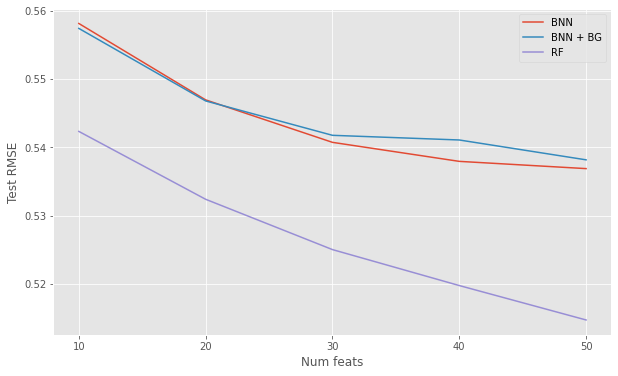

In [39]:
plt.rcParams["figure.figsize"] = (10,6)
for model in ["BNN", "BNN + BG", "RF"]:
    plt.plot(num_feats, bg_bnn_res_zero_out_9c[bg_bnn_res_zero_out_9c["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    plt.xticks(num_feats)
    plt.ylabel("Test RMSE")
    plt.xlabel("Num feats")
    plt.legend()

In [36]:
k = 20
bg_rmse  = bg_bnn_res_zero_out_9c[(bg_bnn_res_zero_out_9c["model"] == "BNN + BG") & (bg_bnn_res_zero_out_9c["num_feats"] == k)]["test_rmse_score"].to_list()
bnn_rmse  = bg_bnn_res_zero_out_9c[(bg_bnn_res_zero_out_9c["model"] == "BNN") & (bg_bnn_res_zero_out_9c["num_feats"] == k)]["test_rmse_score"].to_list()
rf_rmse = bg_bnn_res_zero_out_9c[(bg_bnn_res_zero_out_9c["model"] == "RF") & (bg_bnn_res_zero_out_9c["num_feats"] == k)]["test_rmse_score"].to_list()
bg_bnn_res_zero_out_9c[(bg_bnn_res_zero_out_9c["num_feats"] == k)].groupby(["model", "num_feats"]).mean().iloc[:,1:]

,,test_rmse_score
model,num_feats,
BNN,20,0.546965
BNN + BG,20,0.546811
RF,20,0.532412


In [37]:
stats.ttest_rel(bg_rmse, rf_rmse)

Ttest_relResult(statistic=3.3000719573186488, pvalue=0.004518617887491635)

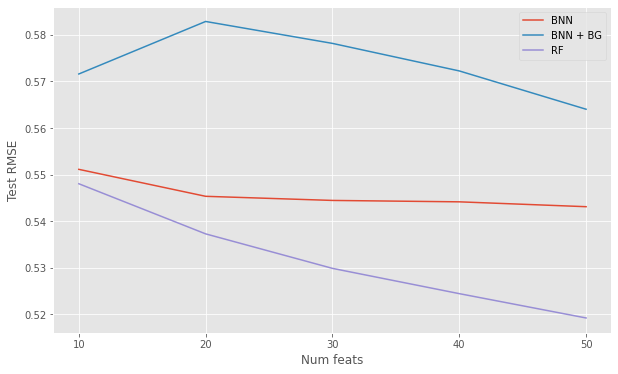

In [45]:
plt.rcParams["figure.figsize"] = (10,6)
for model in ["BNN", "BNN + BG", "RF"]:
    plt.plot(num_feats, bg_bnn_res_zero_out_9f[bg_bnn_res_zero_out_9f["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    plt.xticks(num_feats)
    plt.ylabel("Test RMSE")
    plt.xlabel("Num feats")
    plt.legend()

In [36]:
bg_rmse  = bg_bnn_res_zero_out_9d[(bg_bnn_res_zero_out_9d["model"] == "BNN + BG") & (bg_bnn_res_zero_out_9d["num_feats"] == k)]["test_rmse_score"].to_list()
bnn_rmse  = bg_bnn_res_zero_out_9d[(bg_bnn_res_zero_out_9d["model"] == "BNN") & (bg_bnn_res_zero_out_9d["num_feats"] == k)]["test_rmse_score"].to_list()
rf_rmse = bg_bnn_res_zero_out_9d[(bg_bnn_res_zero_out_9d["model"] == "RF") & (bg_bnn_res_zero_out_9d["num_feats"] == k)]["test_rmse_score"].to_list()
bg_bnn_res_zero_out_9d[(bg_bnn_res_zero_out_9d["num_feats"] == k)].groupby(["model", "num_feats"]).mean().iloc[:,1:]

,,test_rmse_score
model,num_feats,
BNN,20,0.550101
BNN + BG,20,0.552185
RF,20,0.537257


In [56]:
bg_bnn_res_zero_out_9d[(bg_bnn_res_zero_out_9d["num_feats"] == k)]

,seed,model,num_feats,test_rmse_score
3,422,RF,20,0.467902
4,422,BNN,20,0.476825
5,422,BNN + BG,20,0.477959
3,261,RF,20,0.526706
4,261,BNN,20,0.521276
5,261,BNN + BG,20,0.523739
3,968,RF,20,0.555036
4,968,BNN,20,0.553267
5,968,BNN + BG,20,0.550025
3,282,RF,20,0.568548


In [57]:
stats.ttest_rel(bg_rmse, bnn_rmse)

Ttest_relResult(statistic=1.1081128775352531, pvalue=0.2816439743249882)

In [58]:
stats.ttest_rel(bg_rmse, rf_rmse)

Ttest_relResult(statistic=4.0486962271891835, pvalue=0.0006855383672629304)

### Retrain Ranking

In [59]:
import pickle
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import pearsonr
import warnings
import optuna
warnings.filterwarnings("ignore")

num_feats = [10, 20, 30, 40, 50]

def retrain_ranking(seeds, X, y, J):
    J_zero = np.zeros_like(J)
    p = X.shape[1]
    for seed in tqdm(seeds):
        bg_bnn_rf_res_dict = {"seed": [], "model": [], "num_feats": [], "test_rmse_score": []}

        X_train_outer_df, X_test_df, y_train_outer_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

        train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_outer_df)
        train_transformed = train_transformer.transform(X_train_outer_df)
        test_transformed = train_transformer.transform(X_test_df)

        X_train_outer_df = pd.DataFrame(train_transformed, columns=X_train_outer_df.columns)
        X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)

        X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_outer_df, y_train_outer_df, shuffle=True,
                                                                      random_state=seed, test_size=0.2)


        train_indices, val_indices = X_train_df.index.to_list(), X_val_df.index.to_list()
        X_train_outer, y_train_outer = X_train_outer_df.values, y_train_outer_df.values
        X_train, y_train = X_train_df.values, y_train_df.values
        X_val, y_val = X_val_df.values, y_val_df.values
        X_test, y_test = X_test_df.values, y_test_df.values

        torch.manual_seed(seed)
        data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True)


        bnn_bg_config = pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v9c.pkl", "rb"))
        eta, mu_bg= 1.0, bnn_bg_config["mu"]

        if os.path.exists(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v9c.csv"):
            bg_bnn_dropout_loss_df = pd.read_csv(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v9c.csv")
        else:
            bg_bnn_model = init_bg_bnn_model(seed, data_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J, eta, mu_bg, alpha, act_fn)
            bg_states =  pickle.load(open(f"{save_dir}/checkpoints/bg_bnn_states_s_{seed}_v9c.pkl", "rb"))
            bg_disc_states = pickle.load(open(f"{save_dir}/checkpoints/bg_bnn_disc_states_s_{seed}_v9c.pkl", "rb"))
            bg_bnn_dropout_loss_df = get_feats_dropout_loss(bg_bnn_model, bg_states, bg_disc_states, X_val, y_val)
            bg_bnn_dropout_loss_df.to_csv(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v9c.csv", index=False)

        bnn_config = pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v9c.pkl", "rb"))
        eta, mu = 1.0, bnn_config["mu"]
        if os.path.exists(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v9c.csv"):
            bnn_dropout_loss_df = pd.read_csv(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v9c.csv")
        else:

            bnn_model = init_bg_bnn_model(seed, data_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J_zero, eta, mu, alpha, act_fn)
            bnn_states = pickle.load(open(f"{save_dir}/checkpoints/bnn_states_s_{seed}_v9c.pkl", "rb"))
            bnn_disc_states = pickle.load(open(f"{save_dir}/checkpoints/bnn_disc_states_s_{seed}_v9c.pkl", "rb"))
            bnn_dropout_loss_df = get_feats_dropout_loss(bnn_model, bnn_states, bnn_disc_states, X_val, y_val)
            bnn_dropout_loss_df.to_csv(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v9c.csv", index=False)
        #
        if os.path.exists(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl"):
            rf_model = pickle.load(open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "rb"))
        else:
            rf_model = train_rf_model(seed, X_train_outer, y_train_outer, train_indices, val_indices)
            pickle.dump(rf_model, open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "wb"))


        for num_feat in num_feats:
            bg_bnn_feat_idx = bg_bnn_dropout_loss_df["feats_idx"][:num_feat].to_list()
            bnn_feat_idx = bnn_dropout_loss_df["feats_idx"][:num_feat].to_list()
            rf_feat_idx = np.argsort(rf_model.feature_importances_)[::-1][:num_feat]



            ### BNN + BG
            bg_bnn_mask = np.zeros(p)
            bg_bnn_mask[bg_bnn_feat_idx] = 1.0
            X_train_bg_bnn_m, X_test_bg_bnn_m = X_train @ np.diag(bg_bnn_mask),  X_test @ np.diag(bg_bnn_mask)
            torch.manual_seed(seed)
            data_loader_bg = NumpyLoader(NumpyData(X_train_bg_bnn_m, y_train), batch_size=batch_size, shuffle=True)
            bg_bnn_model, bg_states_re, bg_disc_states_re = train_bg_bnn_model(seed, data_loader_bg, epochs, num_cycles, beta, beta_noise, lr_0, disc_lr_0, hidden_sizes, temp, sigma, eta, mu_bg, alpha, J, act_fn)
            rmse_bg_bnn, r2_bg_bnn = score_bg_bnn_model(bg_bnn_model, X_test_bg_bnn_m, y_test, bg_states_re, bg_disc_states_re)

            ## BNN w/o BG
            bnn_mask = np.zeros(p)
            bnn_mask[bnn_feat_idx] = 1.0
            X_train_bnn_m, X_test_bnn_m = X_train @ np.diag(bnn_mask), X_test @ np.diag(bnn_mask)
            data_loader_bnn = NumpyLoader(NumpyData(X_train_bnn_m, y_train), batch_size=batch_size, shuffle=True)
            bnn_model, bnn_states_re, bnn_disc_states_re = train_bg_bnn_model(seed, data_loader_bnn, epochs, num_cycles, beta, beta_noise, lr_0, disc_lr_0, hidden_sizes, temp, sigma, eta, mu, alpha, J_zero, act_fn)
            rmse_bnn, r2_bnn = score_bg_bnn_model(bnn_model, X_test_bnn_m, y_test, bnn_states_re, bnn_disc_states_re)

            ## RF
            rf_mask = np.zeros(p)
            rf_mask[rf_feat_idx] = 1.0
            X_train_rf_m, X_test_rf_m = X_train @ np.diag(rf_mask),  X_test @ np.diag(rf_mask)
            rf_model.fit(X_train_rf_m, y_train)
            rmse_rf, r2_rf = eval_rf_model(rf_model, X_test_rf_m, y_test)

            bg_bnn_rf_res_dict["seed"].append(seed)
            bg_bnn_rf_res_dict["model"].append("RF")
            bg_bnn_rf_res_dict["num_feats"].append(num_feat)
            bg_bnn_rf_res_dict["test_rmse_score"].append(rmse_rf)
            # bg_bnn_rf_res_dict["test_r2_score"].append(r2_rf)

            bg_bnn_rf_res_dict["seed"].append(seed)
            bg_bnn_rf_res_dict["model"].append("BNN")
            bg_bnn_rf_res_dict["num_feats"].append(num_feat)
            bg_bnn_rf_res_dict["test_rmse_score"].append(rmse_bnn)
            # bg_bnn_rf_res_dict["test_r2_score"].append(r2_bnn)


            bg_bnn_rf_res_dict["seed"].append(seed)
            bg_bnn_rf_res_dict["model"].append("BNN + BG")
            bg_bnn_rf_res_dict["num_feats"].append(num_feat)
            bg_bnn_rf_res_dict["test_rmse_score"].append(rmse_bg_bnn)
            # bg_bnn_rf_res_dict["test_r2_score"].append(r2_bg_bnn)



        pd.DataFrame(bg_bnn_rf_res_dict).to_csv(f"{save_dir}/results/feat_retrain_comp_bnn_bg_rf_s_{seed}_v9c.csv", index=False)

    print("Done")

In [60]:
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
retrain_ranking(curr_seeds, X_selected, target, J)

100%|██████████| 20/20 [1:53:48<00:00, 341.45s/it]

Done


In [40]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/feat_retrain_comp_bnn_bg_rf_s_{seed}_v9c.csv")
    res_dfs.append(df)

bg_bnn_res_retrain_9c = pd.concat(res_dfs, axis=0)
# bg_bnn_res_retrain_9c = bg_bnn_res_retrain_9c.drop_duplicates()
bg_bnn_res_retrain_9c.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score
model    num_feats                 
BNN      10                0.525038
         20                0.510743
         30                0.508887
         40                0.501736
         50                0.495603
BNN + BG 10                0.521024
         20                0.511047
         30                0.506719
         40                0.505639
         50                0.498612
RF       10                0.484177
         20                0.485715
         30                0.487930
         40                0.488181
         50                0.485047

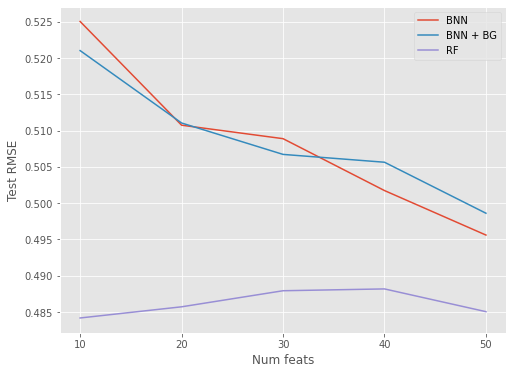

In [62]:
plt.rcParams["figure.figsize"] = (8,6)
for model in ["BNN", "BNN + BG", "RF"]:
    plt.plot(num_feats, bg_bnn_res_retrain_9c[bg_bnn_res_retrain_9c["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    plt.xticks(num_feats)
    plt.ylabel("Test RMSE")
    plt.xlabel("Num feats")
    plt.legend()

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
for model in ["BNN", "BNN + BG", "RF"]:
    plt.plot(num_feats, bg_bnn_res_retrain_9c[bg_bnn_res_retrain_9c["model"] == model].groupby(["num_feats"]).mean()["test_rmse_score"].to_list(), label=model)
    plt.xticks(num_feats)
    plt.ylabel("Test RMSE")
    plt.xlabel("Num feats")
    plt.legend()

In [47]:
k = 50
bg_rmse  = bg_bnn_res_retrain_9c[(bg_bnn_res_retrain_9c["model"] == "BNN + BG") & (bg_bnn_res_retrain_9c["num_feats"] == k)]["test_rmse_score"].to_list()
bnn_rmse  = bg_bnn_res_retrain_9c[(bg_bnn_res_retrain_9c["model"] == "BNN") & (bg_bnn_res_retrain_9c["num_feats"] == k)]["test_rmse_score"].to_list()
rf_rmse = bg_bnn_res_retrain_9c[(bg_bnn_res_retrain_9c["model"] == "RF") & (bg_bnn_res_retrain_9c["num_feats"] == k)]["test_rmse_score"].to_list()
bg_bnn_res_retrain_9c[(bg_bnn_res_retrain_9c["num_feats"] == k)].groupby(["model", "num_feats"]).mean().iloc[:,1:]

,,test_rmse_score
model,num_feats,
BNN,50,0.495603
BNN + BG,50,0.498612
RF,50,0.485047


#### GP

In [62]:
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier, SymbolicRegressor
from gplearn.functions import make_function
import operator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

def get_best_programs(gp, num_models, classifier=True, ascending=True, sort_fit="OOB_fitness"):
    gp_dict = {'Gen': [], "Ind": [], "Fitness": [], 'OOB_fitness': [], "Equation": []}

    if classifier:
        for idGen in range(len(gp._programs)):
            for idPopulation in range(gp.population_size):
                gp_dict["Gen"].append(idGen)
                gp_dict["Ind"].append(idPopulation)
                gp_dict["Fitness"].append(gp._programs[idGen][idPopulation].fitness_)
                gp_dict["OOB_fitness"].append(gp._programs[idGen][idPopulation].oob_fitness_)
                gp_dict["Equation"].append(str(gp._programs[idGen][idPopulation]))
    else:
        for idx, prog in enumerate(gp._programs[-1]):
                gp_dict["Gen"].append(-1)
                gp_dict["Ind"].append(idx)
                gp_dict["Fitness"].append(prog.fitness_)
                gp_dict["OOB_fitness"].append(prog.oob_fitness_)
                gp_dict["Equation"].append(str(prog))

    gp_df = pd.DataFrame(gp_dict).sort_values(sort_fit, ascending=ascending)[:num_models]
    programs = []
    for i in range(num_models):
        gen, ind = int(gp_df.iloc[i]["Gen"]), int(gp_df.iloc[i]["Ind"])
        programs.append(gp._programs[gen][ind])

    return programs, gp_df


def gp_transform(est, X, classifier=False, num_models=100, sort_fit="Fitness"):
    if classifier or (sort_fit == "OOB_fitness"):
        programs, gp_df = get_best_programs(est, num_models, classifier, sort_fit=sort_fit, ascending=classifier)
        out = np.zeros((X.shape[0], len(programs)))
        for i, prog in enumerate(programs):
            out[:, i] = prog.execute(X)

        return out, gp_df
    else:
        return est.transform(X), None

function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos']

def train_linear_model(seed, X_train, X_test, y_train, y_test):
    cv = KFold(n_splits=3, random_state=seed, shuffle=True)
    param_grid = {"alpha": np.logspace(-2, 2, 20)}
    grid_cv = GridSearchCV(estimator=Ridge(max_iter=10000), param_grid=param_grid, 
                                            verbose=0, scoring="r2", cv=cv).fit(X_train, y_train)
    lin_model = Ridge(max_iter=10000, **grid_cv.best_params_)
    lin_model.fit(X_train, y_train)
    y_test_pred = lin_model.predict(X_test)

    test_rmse_score = np.sqrt(np.mean((y_test - y_test_pred)**2))
    test_r2_score = r2_score(y_test, y_test_pred)
    test_pearson, test_pval = stats.pearsonr(y_test, y_test_pred)

    return test_rmse_score, test_r2_score, test_pearson, test_pval

def train_gp(seed, X_train, X_test, y_train, y_test, num_models=5, sort_fit="OOB_fitness", verbose=0, num_gen=100,
                        p_cxvr=0.8, p_subt_mut=0.1, p_hmut=0.05, p_pmut=0.1, subsample=0.8, complexity_coef=0.05):
    gp_est = SymbolicTransformer(population_size=1000, hall_of_fame=200, n_components=50, generations=num_gen,
                                 function_set=function_set,
                           p_crossover=p_cxvr, p_subtree_mutation=p_subt_mut,
                           p_hoist_mutation=p_hmut, p_point_mutation=p_pmut,
                           max_samples=subsample, verbose=verbose,
                           parsimony_coefficient=complexity_coef, random_state=seed)

    gp_est.fit(X_train, y_train)

    gp_features_train, gp_train_df = gp_transform(gp_est, X_train, classifier=False, sort_fit=sort_fit, num_models=num_models)
    gp_features_test, gp_test_df = gp_transform(gp_est, X_test, classifier=False, sort_fit=sort_fit, num_models=num_models)

    X_train_comb = np.concatenate([X_train, gp_features_train], axis=1)
    X_test_comb = np.concatenate([X_test, gp_features_test], axis=1)


    test_rmse_score, test_r2_score, test_pearson, test_pval = train_linear_model(seed, X_train_comb, X_test_comb, y_train, y_test)

    return test_rmse_score, test_r2_score, test_pearson, test_pval, gp_test_df

def train_gp_v2(seed, X_train, X_test, y_train,y_test, verbose=0, num_gen=100,
             p_cxvr=0.8, p_subt_mut=0.1, p_hmut=0.05, p_pmut=0.1, subsample=0.8, complexity_coef=0.05):
    gp_est = SymbolicRegressor(population_size=1000, generations=num_gen,
                                 function_set=function_set,
                                 p_crossover=p_cxvr, p_subtree_mutation=p_subt_mut,
                                 p_hoist_mutation=p_hmut, p_point_mutation=p_pmut,
                                 max_samples=subsample, verbose=verbose,
                                 parsimony_coefficient=complexity_coef, random_state=seed)

    gp_est.fit(X_train, y_train)

    y_test_pred = gp_est.predict(X_test)
    test_rmse_score = np.sqrt(np.mean((y_test - y_test_pred)**2))
    test_r2_score = r2_score(y_test, y_test_pred)
    test_pearson, test_pval = stats.pearsonr(y_test, y_test_pred)

    return test_rmse_score, test_r2_score, test_pearson, test_pval, gp_est

In [70]:
import pickle
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import pearsonr
import warnings
import optuna
warnings.filterwarnings("ignore")

# epochs = 200
# hidden_sizes = [1000, 500, 300, 100]
# num_cycles = 10
# batch_size = 80
# lr_0 = 1e-3
# sigma = 1.0
# eta = 1.0
num_feats = [50]
epochs = 500
num_cycles = 50
batch_size = 16
act_fn = jax.nn.swish
beta = 0.80
lr_0, disc_lr_0 = 1e-3, 1e-3
hidden_sizes = [500]
temp, sigma = 1e-4, 1.0
# eta, mu = 1.0, 1.0
alpha = 1.0

num_gp_models = 5
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"


def cross_val_gp_train(seeds, X, y, J):
    J_zero = np.zeros_like(J)
    i = 0
    for seed in tqdm(seeds):
        rng_key = jax.random.PRNGKey(seed)
        bnn_rf_gp_dict = {"seed": [], "model": [], "num_feats": [], "test_rmse_score": [],
                          "test_r2_score": [], "test_pcc": [], "test_pcc_pval": []}

        X_train_outer_df, X_test_df, y_train_outer_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)

        train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_outer_df)
        train_transformed = train_transformer.transform(X_train_outer_df)
        test_transformed = train_transformer.transform(X_test_df)

        X_train_outer_df = pd.DataFrame(train_transformed, columns=X_train_outer_df.columns)
        X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)

        X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_outer_df, y_train_outer_df, shuffle=True,
                                                                      random_state=seed, test_size=0.2)


        train_indices, val_indices = X_train_df.index.to_list(), X_val_df.index.to_list()
        X_train_outer, y_train_outer = X_train_outer_df.values, y_train_outer_df.values
        X_train, y_train = X_train_df.values, y_train_df.values
        X_val, y_val = X_val_df.values, y_val_df.values
        X_test, y_test = X_test_df.values, y_test_df.values


        # Train BNN and RF models and select features
        torch.manual_seed(seed)
        data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True)
        if os.path.exists(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v9a.csv"):
            bg_bnn_dropout_loss_df = pd.read_csv(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v9a.csv")
        else:
            bnn_bg_config = pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v9a.pkl", "rb"))
            eta, mu = bnn_bg_config["eta"], bnn_bg_config["mu"]
            bg_bnn_model = init_bg_bnn_model(seed, data_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J, eta, mu, alpha, act_fn)
            bg_states =  pickle.load(open(f"{save_dir}/checkpoints/bg_bnn_states_s_{seed}_v9a.pkl", "rb"))
            bg_disc_states = pickle.load(open(f"{save_dir}/checkpoints/bg_bnn_disc_states_s_{seed}_v9a.pkl", "rb"))
            bg_bnn_dropout_loss_df = get_feats_dropout_loss(bg_bnn_model, bg_states, bg_disc_states, X_val, y_val)
            bg_bnn_dropout_loss_df.to_csv(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v9a.csv", index=False)

        if os.path.exists(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v9a.csv"):
            bnn_dropout_loss_df = pd.read_csv(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v9a.csv")
        else:
            bnn_config = pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v9a.pkl", "rb"))
            eta, mu = 1.0, bnn_config["mu"]
            bnn_model = init_bg_bnn_model(seed, data_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J_zero, eta, mu, alpha, act_fn)
            bnn_states = pickle.load(open(f"{save_dir}/checkpoints/bnn_states_s_{seed}_v9a.pkl", "rb"))
            bnn_disc_states = pickle.load(open(f"{save_dir}/checkpoints/bnn_disc_states_s_{seed}_v9a.pkl", "rb"))
            bnn_dropout_loss_df = get_feats_dropout_loss(bnn_model, bnn_states, bnn_disc_states, X_val, y_val)
            bnn_dropout_loss_df.to_csv(f"{save_dir}/dropout/bg_bnn_dropout_loss_s_{seed}_v9a.csv", index=False)

        if os.path.exists(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl"):
            rf_model = pickle.load(open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "rb"))
        else:
            rf_model = train_rf_model(seed, X_train_outer, y_train_outer, train_indices, val_indices)
            pickle.dump(rf_model, open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "wb"))


        for num_feat in num_feats:

            bg_bnn_feat_idx = bg_bnn_dropout_loss_df["feats_idx"][:num_feat].to_list()
            bnn_feat_idx = bnn_dropout_loss_df["feats_idx"][:num_feat].to_list()
            rf_feat_idx = np.argsort(rf_model.feature_importances_)[::-1][:num_feat]

            X_train_2, y_train_2 = jax.random.choice(rng_key, X_train, shape=(X_val.shape[0],), replace=False), jax.random.choice(rng_key, y_train, shape=(X_val.shape[0],), replace=False)

            # Create new validation for training Linear Regression models same size as outer validation
            # X_gp_train_rf, X_gp_train_2_rf, X_gp_val_rf, X_gp_test_rf = X_val[:,rf_feat_idx], X_train_2[:,rf_feat_idx], X_train[:,rf_feat_idx], X_test[:,rf_feat_idx]
            # X_gp_train_bg_bnn, X_gp_train_2_bg_bnn, X_gp_val_bg_bnn, X_gp_test_bg_bnn = X_val[:,bg_bnn_feat_idx], X_train_2[:,bg_bnn_feat_idx], X_train[:,bg_bnn_feat_idx], X_test[:,bg_bnn_feat_idx]
            # X_gp_train_bnn, X_gp_train_2_bnn, X_gp_val_bnn, X_gp_test_bnn = X_val[:,bnn_feat_idx], X_train_2[:,bnn_feat_idx], X_train[:,bnn_feat_idx], X_test[:,bnn_feat_idx]
            X_gp_train_rf, X_gp_test_rf = X_train[:,rf_feat_idx], X_test[:,rf_feat_idx]
            X_gp_train_bg_bnn, X_gp_test_bg_bnn = X_train[:,bg_bnn_feat_idx], X_test[:,bg_bnn_feat_idx]
            X_gp_train_bnn, X_gp_test_bnn = X_train[:,bnn_feat_idx], X_test[:,bnn_feat_idx]

            y_train_gp, y_test_gp = y_train, y_test

            ## Run LR
            bnn_test_rmse_score, bnn_test_r2_score, bnn_test_pcc, bnn_test_pval = train_linear_model(seed, X_gp_train_bnn, X_gp_test_bnn, y_train, y_test_gp)
            rf_test_rmse_score, rf_test_r2_score, rf_test_pcc, rf_test_pval = train_linear_model(seed, X_gp_train_rf, X_gp_test_rf, y_train, y_test_gp)
            bg_bnn_test_rmse_score, bg_bnn_test_r2_score, bg_bnn_test_pcc, bg_bnn_test_pval = train_linear_model(seed, X_gp_train_bg_bnn, X_gp_test_bg_bnn, y_train, y_test_gp)

            ## Run GP + LR
            bg_bnn_gp_test_rmse_score, bg_bnn_gp_test_r2_score, bg_bnn_gp_test_pcc, bg_bnn_gp_test_pval, _ = train_gp(seed, X_gp_train_bg_bnn, X_gp_test_bg_bnn,
                                                                                                          y_train_gp, y_test_gp, num_models=num_gp_models, verbose=0, p_cxvr=0.8, p_subt_mut=0.05,
                                                                                                          p_hmut=0.05, p_pmut=0.05, complexity_coef=0.001)

            bnn_gp_test_rmse_score, bnn_gp_test_r2_score, bnn_gp_test_pcc, bnn_gp_test_pval, _ = train_gp(seed, X_gp_train_bnn, X_gp_test_bnn,
                                                                                                          y_train_gp, y_test_gp, num_models=num_gp_models, verbose=0, p_cxvr=0.8, p_subt_mut=0.05,
                                                                                                          p_hmut=0.05, p_pmut=0.05, complexity_coef=0.001)


            rf_gp_test_rmse_score, rf_gp_test_r2_score, rf_gp_test_pcc, rf_gp_test_pval, _ = train_gp(seed, X_gp_train_rf, X_gp_test_rf,
                                                                                                      y_train_gp, y_test_gp, num_models=num_gp_models, verbose=0, p_cxvr=0.8, p_subt_mut=0.05,
                                                                                                      p_hmut=0.05, p_pmut=0.05, complexity_coef=0.001)


            # ======================== Save scores for compressed models =========================

            bnn_rf_gp_dict["seed"].append(seed)
            bnn_rf_gp_dict["model"].append("RF + LR")
            bnn_rf_gp_dict["num_feats"].append(num_feat)
            bnn_rf_gp_dict["test_rmse_score"].append(rf_test_rmse_score)
            bnn_rf_gp_dict["test_r2_score"].append(rf_test_r2_score)
            bnn_rf_gp_dict["test_pcc"].append(rf_test_pcc)
            bnn_rf_gp_dict["test_pcc_pval"].append(rf_test_pval)

            bnn_rf_gp_dict["seed"].append(seed)
            bnn_rf_gp_dict["model"].append("RF + LR + GP")
            bnn_rf_gp_dict["num_feats"].append(num_feat)
            bnn_rf_gp_dict["test_rmse_score"].append(rf_gp_test_rmse_score)
            bnn_rf_gp_dict["test_r2_score"].append(rf_gp_test_r2_score)
            bnn_rf_gp_dict["test_pcc"].append(rf_gp_test_pcc)
            bnn_rf_gp_dict["test_pcc_pval"].append(rf_gp_test_pval)

            bnn_rf_gp_dict["seed"].append(seed)
            bnn_rf_gp_dict["model"].append("BNN + LR")
            bnn_rf_gp_dict["num_feats"].append(num_feat)
            bnn_rf_gp_dict["test_rmse_score"].append(bnn_test_rmse_score)
            bnn_rf_gp_dict["test_r2_score"].append(bnn_test_r2_score)
            bnn_rf_gp_dict["test_pcc"].append(bnn_test_pcc)
            bnn_rf_gp_dict["test_pcc_pval"].append(bnn_test_pval)


            bnn_rf_gp_dict["seed"].append(seed)
            bnn_rf_gp_dict["model"].append("BNN + LR + GP")
            bnn_rf_gp_dict["num_feats"].append(num_feat)
            bnn_rf_gp_dict["test_rmse_score"].append(bnn_gp_test_rmse_score)
            bnn_rf_gp_dict["test_r2_score"].append(bnn_gp_test_r2_score)
            bnn_rf_gp_dict["test_pcc"].append(bnn_gp_test_pcc)
            bnn_rf_gp_dict["test_pcc_pval"].append(bnn_gp_test_pval)

            bnn_rf_gp_dict["seed"].append(seed)
            bnn_rf_gp_dict["model"].append("BNN + BG + LR")
            bnn_rf_gp_dict["num_feats"].append(num_feat)
            bnn_rf_gp_dict["test_rmse_score"].append(bg_bnn_test_rmse_score)
            bnn_rf_gp_dict["test_r2_score"].append(bg_bnn_test_r2_score)
            bnn_rf_gp_dict["test_pcc"].append(bg_bnn_test_pcc)
            bnn_rf_gp_dict["test_pcc_pval"].append(bg_bnn_test_pval)


            bnn_rf_gp_dict["seed"].append(seed)
            bnn_rf_gp_dict["model"].append("BNN + BG + LR + GP")
            bnn_rf_gp_dict["num_feats"].append(num_feat)
            bnn_rf_gp_dict["test_rmse_score"].append(bg_bnn_gp_test_rmse_score)
            bnn_rf_gp_dict["test_r2_score"].append(bg_bnn_gp_test_r2_score)
            bnn_rf_gp_dict["test_pcc"].append(bg_bnn_gp_test_pcc)
            bnn_rf_gp_dict["test_pcc_pval"].append(bg_bnn_gp_test_pval)



        pd.DataFrame(bnn_rf_gp_dict).to_csv(f"{save_dir}/results/model_comp_bnn_bg_rf_s_{seed}_v9a.csv", index=False)


        i += 1


    print("Done")

In [73]:
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds[5:10]
bnn_rf_gp_dict = cross_val_gp_train(curr_seeds, X_selected, target, J)

100%|██████████| 5/5 [31:05<00:00, 373.06s/it]

Done


In [74]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57]
res_dfs = []
for seed in seeds[:10]:
    df = pd.read_csv(f"{save_dir}/results/model_comp_bnn_bg_rf_s_{seed}_v9b.csv")
    res_dfs.append(df)

gp_bg_bnn_rf_df_9a = pd.concat(res_dfs, axis=0)
gp_bg_bnn_rf_df_9a.groupby(["model", "num_feats"]).mean().iloc[:,1:]

,,test_rmse_score,test_r2_score,test_pcc,test_pcc_pval
model,num_feats,,,,
BNN + BG + LR,50,0.511521,0.118143,0.409041,0.000681
BNN + BG + LR + GP,50,0.530124,0.052099,0.386198,0.002462
BNN + LR,50,0.519739,0.089570,0.384870,0.004507
BNN + LR + GP,50,0.541219,0.011248,0.364772,0.007797
RF + LR,50,0.486262,0.198384,0.472615,0.000355
RF + LR + GP,50,0.503325,0.136621,0.453537,0.000509


In [9]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57]
res_dfs = []
for seed in curr_seeds:
    df = pd.read_csv(f"{save_dir}/results/model_comp_bnn_bg_rf_s_{seed}_v9a.csv")
    res_dfs.append(df)

gp_bg_bnn_rf_df_9a = pd.concat(res_dfs, axis=0)
gp_bg_bnn_rf_df_9a.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score  test_r2_score  test_pcc  \
model         num_feats                                             
BNN + LR      10                0.537268       0.047827  0.268009   
              20                0.537873       0.046022  0.312778   
              30                0.545694       0.014559  0.314402   
              40                0.548733       0.005249  0.325595   
              50                0.562054      -0.041952  0.303852   
BNN + LR + GP 10                0.596980      -0.262101  0.217735   
              20                0.573259      -0.098103  0.275400   
              30                0.566625      -0.070660  0.304064   
              40                0.563732      -0.056073  0.311494   
              50                0.574822      -0.094130  0.299497   
RF + LR       10                0.494575       0.197003  0.458374   
              20                0.493651       0.197615  0.465853   
              30                0.488648       0.215022  0.480978   
              40                0.492449       0.202834  0.474456   
              50                0.494120       0.197730  0.473012   
RF + LR + GP  10                0.544896      -0.109444  0.429179   
              20                0.497218       0.185374  0.458679   
              30                0.494995       0.194069  0.471333   
              40                0.500833       0.174388  0.460211   
              50                0.501782       0.171145  0.459229   

                         test_pcc_pval  
model         num_feats                 
BNN + LR      10              0.119289  
              20              0.027440  
              30              0.031976  
              40              0.036093  
              50              0.043030  
BNN + LR + GP 10              0.199679  
              20              0.056152  
              30              0.041436  
              40              0.049129  
              50              0.058287  
RF + LR       10              0.000611  
              20              0.001160  
              30              0.000446  
              40              0.000963  
              50              0.001095  
RF + LR + GP  10              0.037417  
              20              0.001031  
              30              0.000402  
              40              0.001183  
              50              0.001432

In [ ]:
gp_bg_bnn_rf_df_9a

In [10]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57]
res_dfs = []
for seed in seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_bg_rf_s_{seed}_v5.csv")
    res_dfs.append(df)

bnn_rf_df = pd.concat(res_dfs, axis=0)
bnn_rf_df.groupby(["model"]).mean().iloc[:,1:]

,test_rmse_score,test_r2_score
model,,
BNN + BG,0.481284,0.238046
RF,0.479711,0.245956


In [11]:
bnn_rf_df

,seed,model,test_rmse_score,test_r2_score
0,422,RF,0.407726,0.278194
1,422,BNN + BG,0.442979,0.147982
0,261,RF,0.478135,0.194252
1,261,BNN + BG,0.479764,0.188752
0,968,RF,0.495877,0.232576
1,968,BNN + BG,0.503923,0.207468
0,282,RF,0.513891,0.242852
1,282,BNN + BG,0.507014,0.262980
0,739,RF,0.431555,0.240847
1,739,BNN + BG,0.481845,0.053607


In [24]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
res_dfs = []
for seed in seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_bg_rf_s_{seed}_v3.csv")
    res_dfs.append(df)

bnn_rf_df = pd.concat(res_dfs, axis=0)
bnn_rf_df.groupby(["model"]).mean().iloc[:,1:]

,test_rmse_score,test_r2_score
model,,
BNN + BG,0.496011,0.189143
RF,0.479711,0.245956


In [24]:
bnn_rf_gp_lsw = pd.read_csv(f"{save_dir}/bnn_rf_gp_feature_sel_summary.csv")
bnn_rf_gp_lsw = bnn_rf_gp_lsw.drop_duplicates().drop("Unnamed: 0", axis=1)
bnn_rf_gp_lsw.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score  test_r2_score  test_pcc  \
model         num_feats                                             
BNN + LR      20                0.549379       0.003239  0.271716   
              40                0.546482       0.013174  0.337297   
              60                0.554629      -0.018310  0.335159   
BNN + LR + GP 20                0.555483      -0.019855  0.263980   
              40                0.550449      -0.001111  0.332696   
              60                0.561666      -0.044314  0.326638   
RF + LR       20                0.495686       0.191597  0.460010   
              40                0.503463       0.165533  0.452178   
              60                0.509864       0.141250  0.431336   
RF + LR + GP  20                0.498977       0.180815  0.456942   
              40                0.503225       0.165837  0.453768   
              60                0.511880       0.133692  0.432519   

                         test_pcc_pval  
model         num_feats                 
BNN + LR      20              0.103979  
              40              0.019269  
              60              0.026847  
BNN + LR + GP 20              0.093821  
              40              0.024275  
              60              0.030761  
RF + LR       20              0.000520  
              40              0.000141  
              60              0.000862  
RF + LR + GP  20              0.000486  
              40              0.000171  
              60              0.000989

In [57]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
seeds = [422,261,968,282,739,573,220,413,745,775]
res_dfs = []
for seed in seeds:
    /notebooks/exp_data_5/cancer/gdsc/bnn_rf_gp_df_dropout.csv
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_gp_s_{seed}_v4.csv")
    res_dfs.append(df)

bnn_rf_gp_df = pd.concat(res_dfs, axis=0)
bnn_rf_gp_df.groupby(["model", "num_feats"]).mean().iloc[:,1:]

,,test_rmse_score,test_r2_score,test_pcc,test_pcc_pval
model,num_feats,,,,
BNN + LR,20,0.535148,0.059113,0.310668,0.050418
BNN + LR + GP,20,0.553210,-0.009103,0.280440,0.094543
RF + LR,20,0.495686,0.191597,0.460010,0.000520
RF + LR + GP,20,0.499409,0.179732,0.457535,0.000252


In [58]:
bnn_rf_gp_df

,seed,model,num_feats,test_rmse_score,test_r2_score,test_pcc,test_pcc_pval
0,422,RF + LR,20,0.445575,0.137967,0.441134,0.000034
1,422,RF + LR + GP,20,0.440351,0.158062,0.437110,0.000040
2,422,BNN + LR,20,0.446160,0.135702,0.378847,0.000449
3,422,BNN + LR + GP,20,0.432252,0.188745,0.438863,0.000037
0,261,RF + LR,20,0.515131,0.064735,0.299998,0.006176
...,...,...,...,...,...,...,...
3,226,BNN + LR + GP,20,0.580038,0.131860,0.382773,0.000387
0,196,RF + LR,20,0.497757,0.171029,0.438416,0.000038
1,196,RF + LR + GP,20,0.497990,0.170254,0.439247,0.000037
2,196,BNN + LR,20,0.535433,0.040789,0.296835,0.006769


In [4]:
import pandas as pd
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
df = pd.read_csv(f"{save_dir}/bnn_rf_gp_df_dropout.csv")
df.groupby(["model"]).mean()

,seed,test_rmse_score,test_r2_score,test_pcc,test_pcc_pval
model,,,,,
BNN + LR,539.8,0.588019,-0.173377,0.255526,0.073057
BNN + LR + GP,539.8,0.592641,-0.191702,0.252452,0.086305
RF + LR,539.8,0.512898,0.109117,0.407862,0.000725
RF + LR + GP,539.8,0.516063,0.097912,0.406975,0.000834
